In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
cust_df = pd.read_csv('./Customers.csv')
pro_df = pd.read_csv('./Products.csv')
tx_df = pd.read_csv('./Transactions.csv')

In [4]:
# Convert dates to datetime
cust_df['SignupDate'] = pd.to_datetime(cust_df['SignupDate'])
tx_df['TransactionDate'] = pd.to_datetime(tx_df['TransactionDate'])
tx_pro = pd.merge(tx_df, pro_df[['ProductID','ProductName', 'Category']] , on='ProductID', how='left')
rec_tx_date = tx_pro['TransactionDate'].max()
reg_cust = pd.get_dummies(cust_df['Region'], prefix='Region')
cust_ohe = pd.concat([cust_df[['CustomerID']], reg_cust], axis=1)
tx_stats = tx_pro.groupby('CustomerID').agg(
    transaction_count=('TransactionID', 'count'),
    total_quantity=('Quantity', 'sum'),
    total_value=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    avg_quantity_per_transaction=('Quantity', 'mean'),
    first_transaction_date=('TransactionDate', 'min'),
    last_transaction_date=('TransactionDate', 'max'),
    unique_products=('ProductID', 'nunique'),
    unique_categories=('Category', 'nunique'),
    avg_price=('Price', 'mean')
).reset_index()
tx_stats['activity_duration'] = (tx_stats['last_transaction_date'] - tx_stats['first_transaction_date']).dt.days
tx_stats['recency'] = (rec_tx_date - tx_stats['last_transaction_date']).dt.days
tx_stats.drop(['first_transaction_date', 'last_transaction_date'], axis=1, inplace=True)
df = pd.merge(tx_stats, cust_ohe, on='CustomerID', how='left')
cust_ids = df['CustomerID']
df.drop(columns=['CustomerID'], inplace=True)

In [5]:
from sklearn.cluster import KMeans 
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

wcss = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

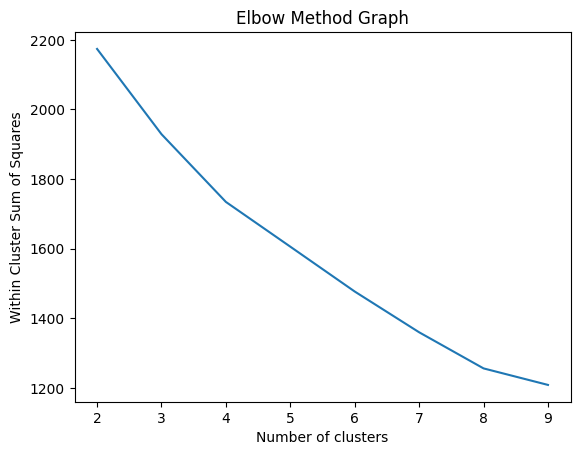

In [6]:
plt.plot(range(2,10), wcss)
plt.title('Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

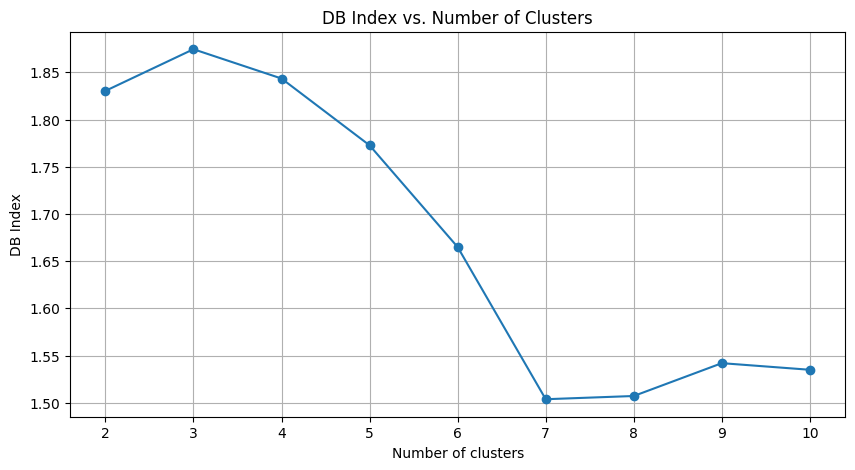

Optimal number of clusters: 7
DB Index for K=7: 1.504
Silhouette Score for K=7: 0.195


In [7]:
db_scores = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)
    db_scores.append(davies_bouldin_score(scaled_df, labels))
    silhouette_scores.append(silhouette_score(scaled_df, labels))

# Plot metrics
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), db_scores, marker='o', label='DB Index')
plt.xlabel('Number of clusters')
plt.ylabel('DB Index')
plt.title('DB Index vs. Number of Clusters')
plt.grid()
plt.show()

# Optimal K based on lowest DB Index
optimal_k = np.argmin(db_scores) + 2  # Since K starts at 2
print(f"Optimal number of clusters: {optimal_k}")
print(f"DB Index for K={optimal_k}: {db_scores[optimal_k-2]:.3f}")
print(f"Silhouette Score for K={optimal_k}: {silhouette_scores[optimal_k-2]:.3f}")

In [11]:
np.argmin(silhouette_scores)

np.int64(2)

In [ ]:
## Through elbow method & silhouette_score , k=4 is the optimal number of clusters

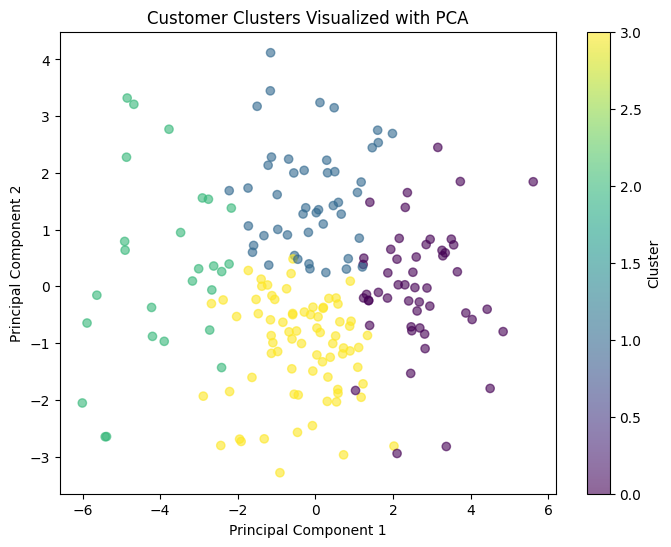

In [35]:
# Visualize clusters using PCA
# Final clustering with optimal K
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(scaled_df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title('Customer Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()